# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
# from matplotlib import style
import seaborn as sns
import warnings
import sys
import os

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
warnings.filterwarnings("ignore")
%matplotlib inline

Let's generate our dataset and take a look on it.

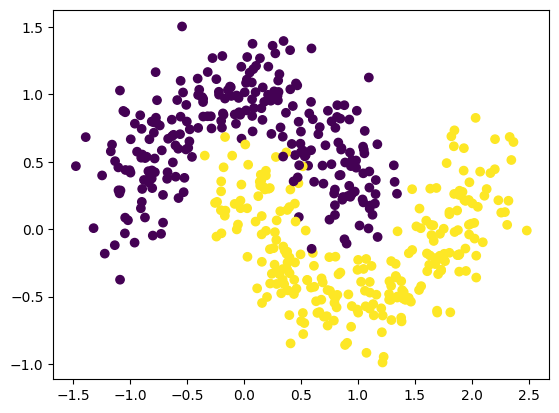

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels, cmap='viridis')

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib.gridspec import GridSpec

from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score


lr = LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1)
svm = SVC(kernel='linear')

In [4]:
def plot_decisions(X, Y, estimators, name_estimators, size_graph, figsize_graph, position_graph=None):
    gs = GridSpec(size_graph[0], size_graph[1])
    accuracy_error = []
    for curr_est in estimators:
        curr_est.fit(X, Y)
    plt.figure(figsize=figsize_graph)
    for i, est_name in enumerate(name_estimators):
        plt.subplot(size_graph[0], size_graph[1], i + 1)
        plt.title(est_name + '\n' + f'accuracy_score = {accuracy_score(Y, estimators[i].predict(X))}')
        plot_decision_regions(X, Y, clf=estimators[i], n_jobs=-1)
    plt.subplots_adjust()

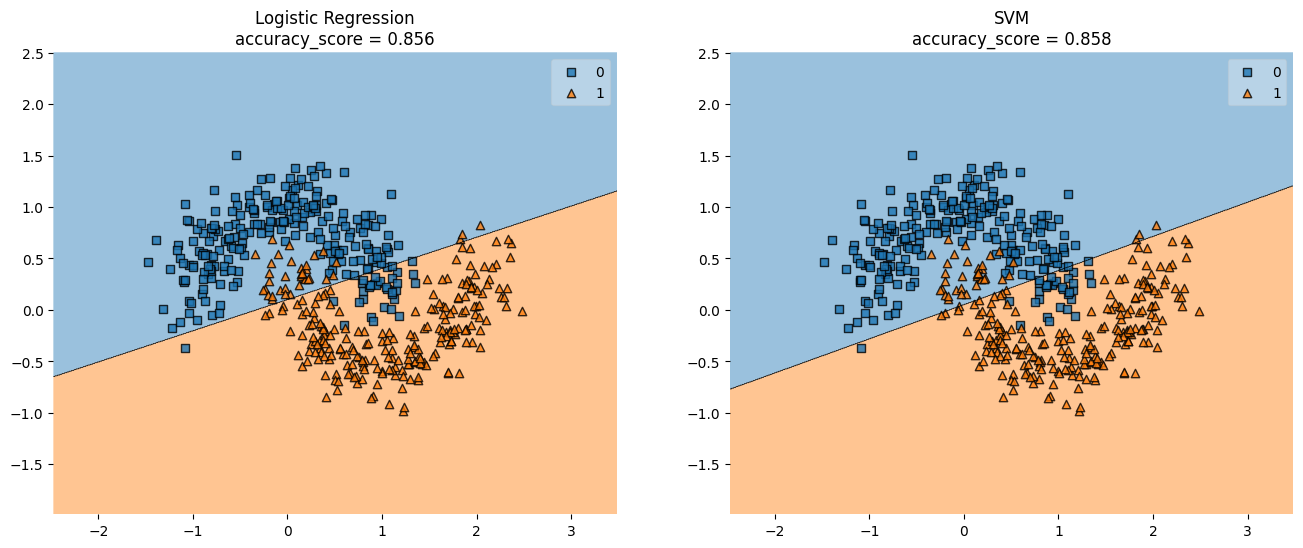

In [5]:
plot_decisions(
    moons_points, moons_labels, [lr, svm],
    ['Logistic Regression', 'SVM'],
    (1, 2), (16, 6)
)

Both results are about the same. This is expected because both models optimized the line, but they did it with different algorithms and optimized different loss functions.

## 1.2 Kernel tirck

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


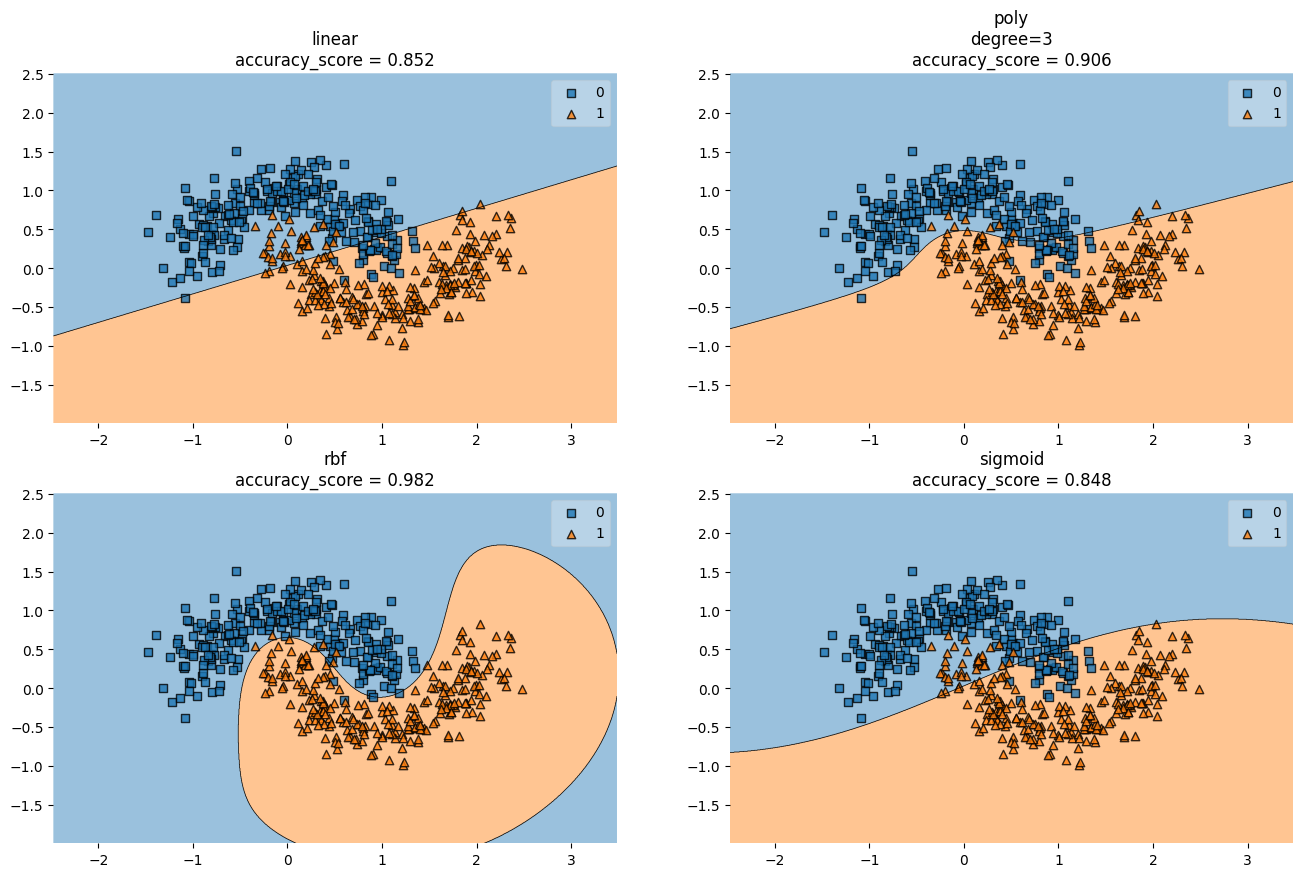

In [7]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'C': np.linspace(1e-3, 15, 50),
    # 'degree': np.arange(1, 10, 1),  # 'degree'
    'gamma': np.linspace(0, 1, 10), #  ‘rbf’, ‘poly’ and ‘sigmoid’
}

svm_linear = SVC(kernel='linear', probability=True)
svm_linear_cv = GridSearchCV(estimator=svm_linear, param_grid={'C': np.linspace(1e-3, 15, 50)}, cv=5,
                             n_jobs=-1, verbose=True).fit(moons_points, moons_labels).best_estimator_

svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf_cv = GridSearchCV(estimator=svm_rbf, param_grid=grid_params, cv=5, 
                           n_jobs=-1, verbose=True).fit(moons_points, moons_labels).best_estimator_

svm_sigmoid = SVC(kernel='sigmoid', probability=True)
svm_sigmoid_cv = GridSearchCV(estimator=svm_sigmoid, param_grid=grid_params, cv=5, 
                            n_jobs=-1, verbose=True).fit(moons_points, moons_labels).best_estimator_

grid_params['degree'] = np.arange(1, 10, 1)
svm_poly = SVC(kernel='poly', probability=True)
svm_poly_cv = GridSearchCV(estimator=svm_poly, param_grid=grid_params, cv=5, 
                            n_jobs=-1, verbose=True).fit(moons_points, moons_labels).best_estimator_

plot_decisions(
    moons_points, moons_labels, 
    [svm_linear_cv, svm_poly_cv, svm_rbf_cv, svm_sigmoid_cv],
    ['linear', f'poly\ndegree={svm_poly_cv.degree}', 'rbf', 'sigmoid'], (2, 2), (16, 10)
)

In [8]:
svm_poly_cv.degree

3

So, As we can see sigmoid kernel worked even worse than others kernels.

`poly` and `rbf` performed about equally well, much better than `linear`. It is worth noting that in the case of `rbf` we observe that the curve is closed, in `poly` we observe nothing of the kind.

The best degree polynomial for the polynomial kernel is 9.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import colormaps


x_min, x_max = -2.2, 3.2
y_min, y_max = -1.6, 2.5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, np.abs((x_max / x_min) / 100)), 
    np.arange(y_min, y_max, np.abs((x_max / x_min) / 100))
)
X_plot = np.c_[xx.ravel(), yy.ravel()]

In [10]:
param_grid =  {
    'C' : np.logspace(1e-3, 10, 20),
    'solver' : ['newton-cg','liblinear','sag','saga'],
}

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


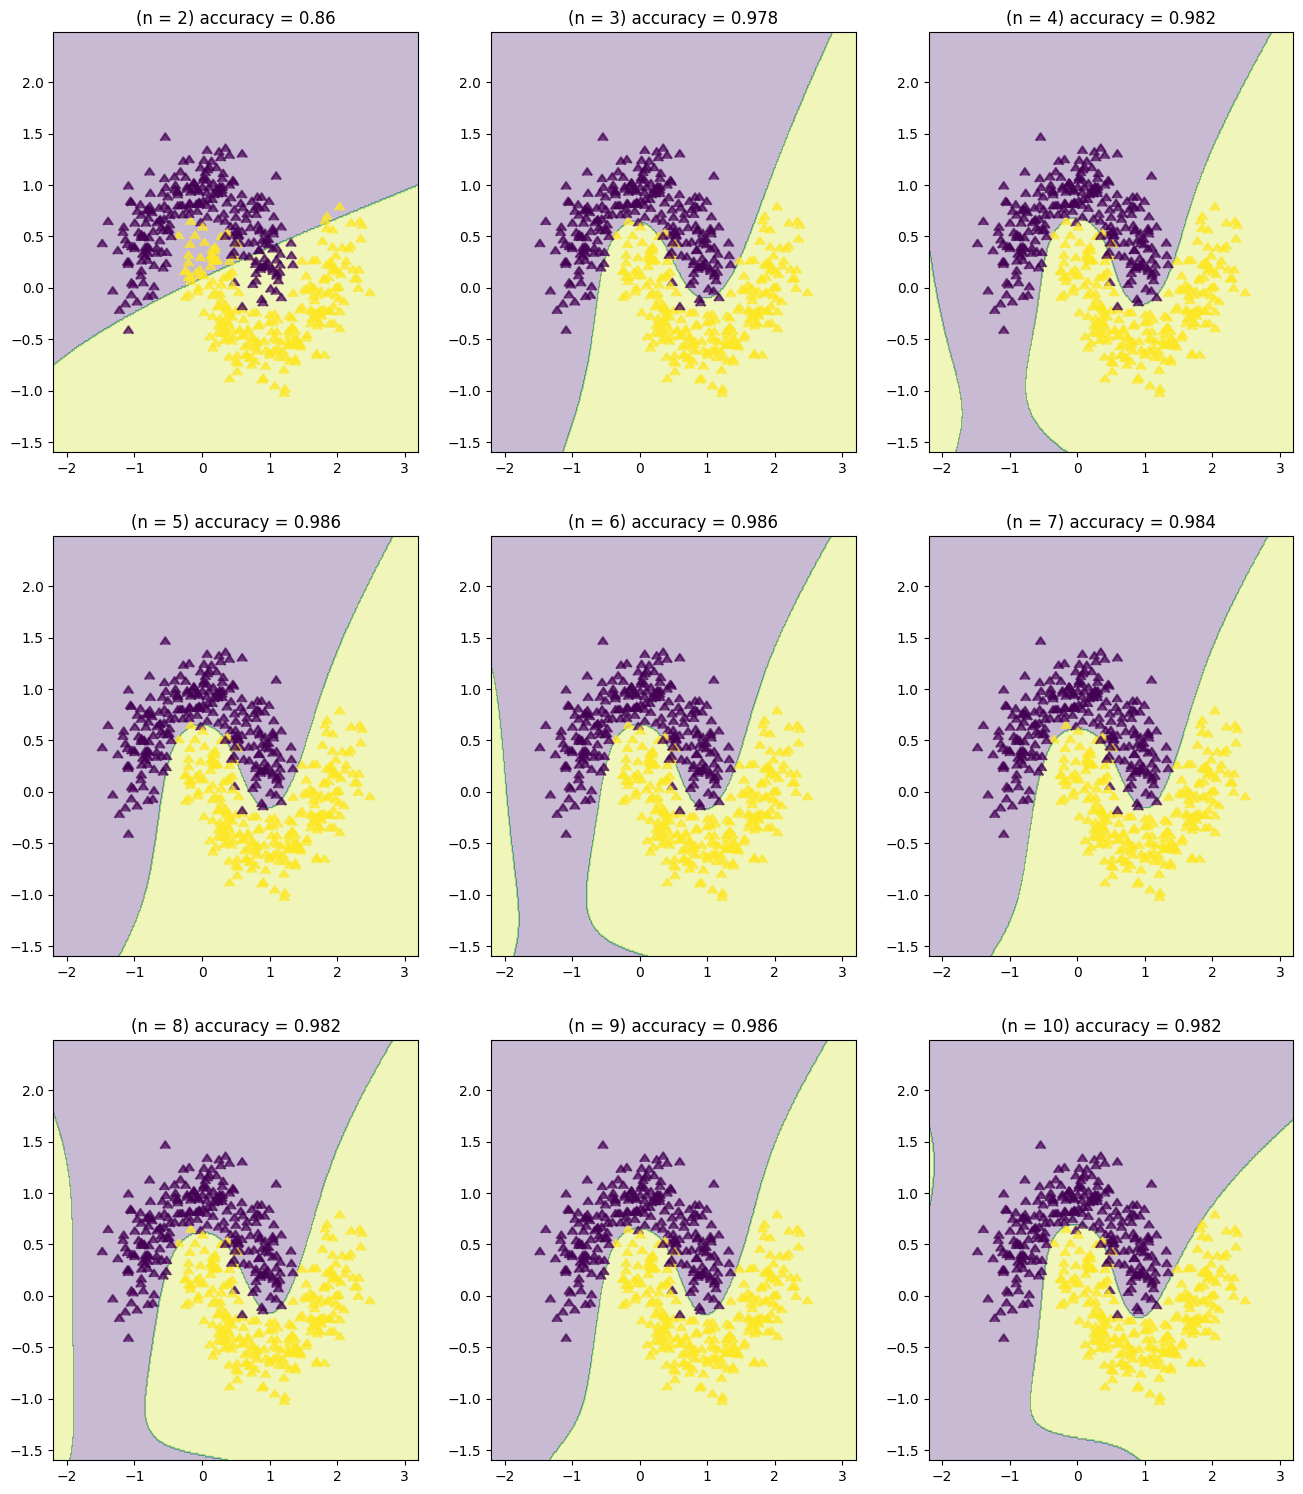

In [11]:
grid_degrees = np.arange(2, 11, 1)
plt.figure(figsize=(16, 12))

for curr_degree in grid_degrees:
    poly_features = PolynomialFeatures(curr_degree)
    poly_moons_points = poly_features.fit_transform(moons_points)
    lr = LogisticRegression(max_iter=1000)
    cv_lr = GridSearchCV(lr, param_grid=param_grid, cv = 5, n_jobs=-1, verbose=True)
    cv_lr.fit(poly_moons_points, moons_labels)
    lr_predict = cv_lr.predict(poly_moons_points)
    
    polinomial_x_plot = poly_features.transform(X_plot)
    plt.subplot(3, 3, curr_degree - 1)
    plt.title(f'(n = {curr_degree}) accuracy = {round(accuracy_score(moons_labels, lr_predict), 3)}')
    plt.contourf(xx, yy, cv_lr.predict(polinomial_x_plot).reshape(xx.shape), cmap='viridis', alpha=0.3)
    plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels, s=50, cmap='viridis', marker=6, alpha=0.7)
plt.subplots_adjust(top=1.3)

After the 5-6th degree, we are closer in accuracy to SVM. This means that by generating additional features that are nonlinearly dependent on each other, we can improve the model quite significantly

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

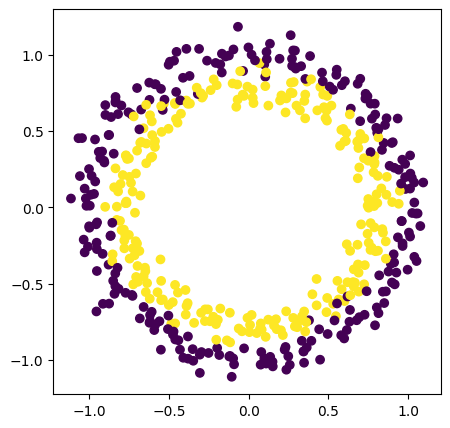

In [12]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels, cmap='viridis')

And even more:

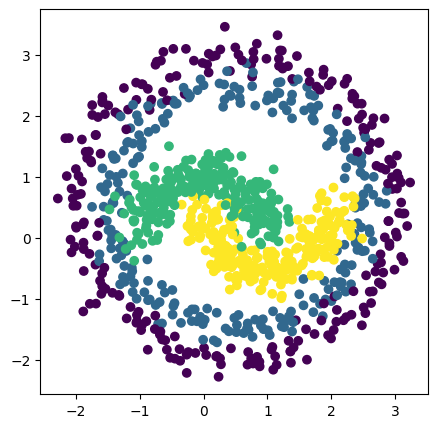

In [13]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='viridis')

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

In [16]:
x_min, x_max = -2.8, 3.8
y_min, y_max = -2.8, 3.8
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, np.abs((x_max / x_min) / 100)), 
    np.arange(y_min, y_max, np.abs((x_max / x_min) / 100))
)
X_plot = np.c_[xx.ravel(), yy.ravel()]

In [17]:
grid_degrees = np.arange(2, 8, 1)

param_grids =  {
    'C' : np.logspace(1e-3, 7, 25),
}

model_degrees = dict()

for curr_degree in grid_degrees:
    poly_features = PolynomialFeatures(curr_degree)
    poly_points = poly_features.fit_transform(points)
    lr = LogisticRegression(max_iter=1000)
    cv_lr = GridSearchCV(
        lr, param_grid=param_grids, cv=5, n_jobs=-1,
        verbose=True).fit(poly_points, labels).best_estimator_
    lr_predict = cv_lr.predict(poly_points)
    model_degrees[curr_degree] = {
        'model': cv_lr,
        'score': accuracy_score(labels, lr_predict),
        'polinomial_x_plot': poly_features.transform(X_plot)                   
    }

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


Text(0.5, 0, 'degree')

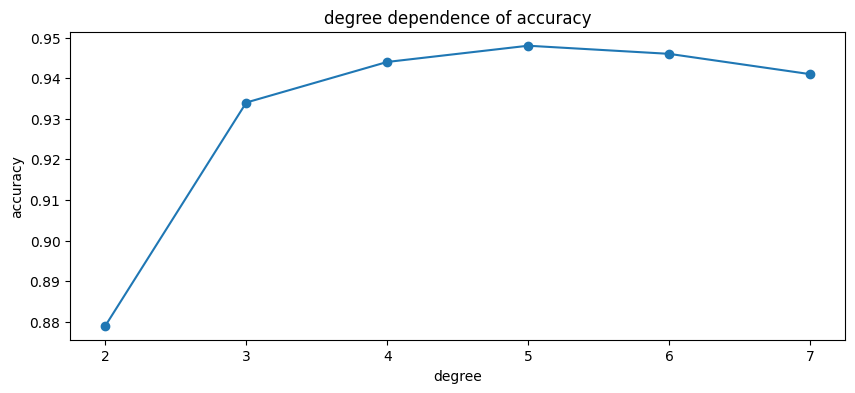

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(model_degrees.keys(), [item['score'] for item in model_degrees.values()])
plt.scatter(model_degrees.keys(), [item['score'] for item in model_degrees.values()]) ######
plt.title('degree dependence of accuracy')
plt.ylabel('accuracy')
plt.xlabel('degree')

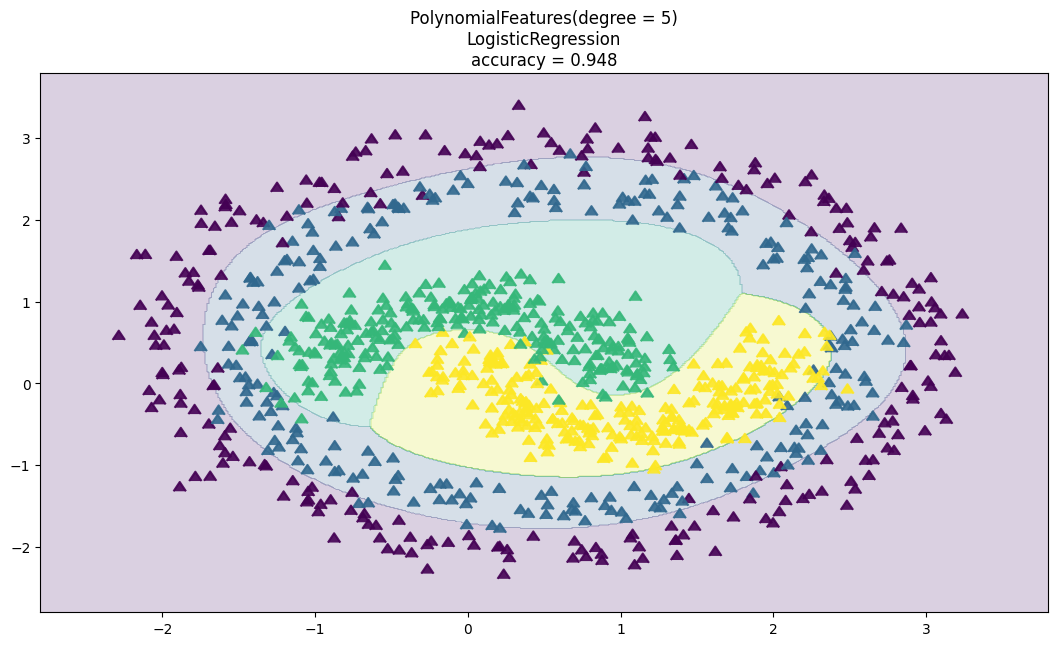

In [26]:
degree = 5 # Optimal degree
model = model_degrees[degree]['model']
score = model_degrees[degree]['score']
plt.figure(figsize=(13, 7))
polinomial_x_plot = model_degrees[degree]['polinomial_x_plot']
plt.contourf(xx, yy, model.predict(polinomial_x_plot).reshape(xx.shape), cmap='viridis', alpha=0.2) # GnBu
plt.scatter(points[:, 0], points[:, 1], c=labels, s=80, cmap='viridis', marker=6, alpha=0.9) # viridis
plt.title(f'PolynomialFeatures(degree = {degree})\nLogisticRegression\naccuracy = {score}')
plt.show()

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


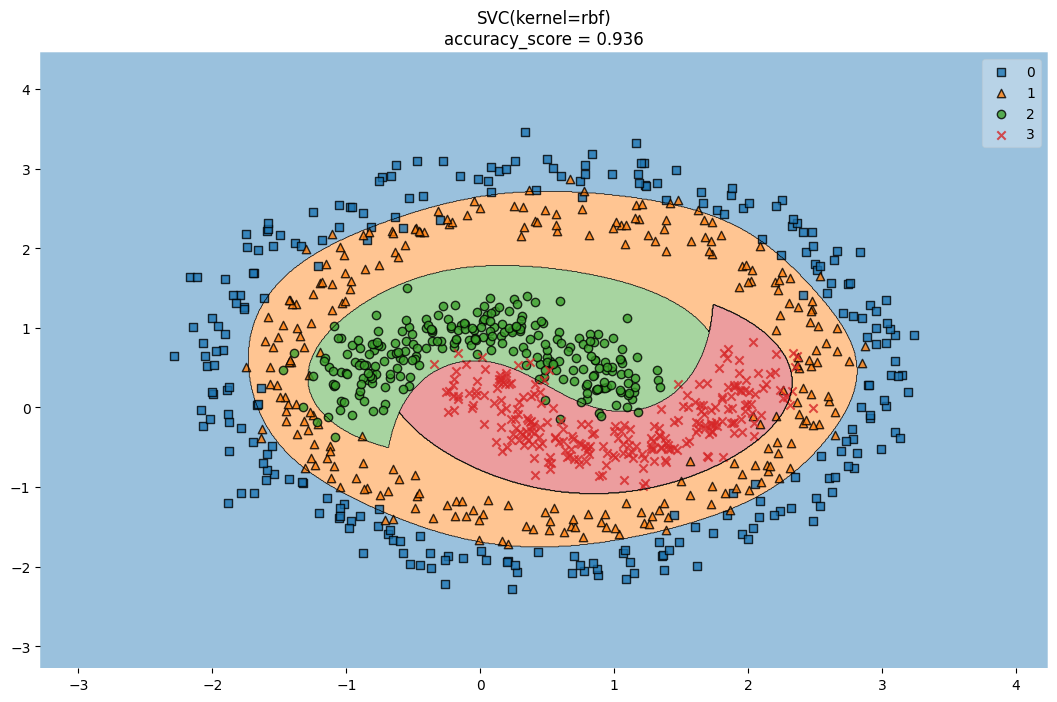

In [25]:
grid_params = {
    'C': np.linspace(1e-3, 5, 20),
    'gamma': np.linspace(0, 1, 10)
}

svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf_cv = GridSearchCV(estimator=svm_rbf, param_grid=grid_params, cv=5, 
                           n_jobs=-1, verbose=True).fit(points, labels).best_estimator_

plot_decisions(
    points, labels, 
    [svm_rbf_cv],
    ['SVC(kernel=rbf)'], 
    (1, 1), (13, 8)
)